In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
import seaborn as sns
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

## Recurrant Neural Networks

The RNN type of network and its uses mirror that of a CNN - while the convolutional neural networks excel at capturing spatial relationships in data, RNNs excel at capturing temporal relationships, or things that change over time. This leads to this type of network to be well suited to time series types of problems, and also things like text processing, where the words that occur earlier in a sentence are connected to those that occur later. 

![RNN](images/rnn.png "RNN" )

### Long Short Term Memory

Long Short Term Memory (lstm) models are a type of RNN that we can commonly use to make time series predictions. LSTM models function to "remember" certain data and carry that forward, and forget other data. 

![LSTM](images/lstm.png "LSTM" )



### Past Model

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
21/21 [==============================] - 3s 33ms/step - loss: 0.1261
Epoch 2/100
21/21 [==============================] - 1s 38ms/step - loss: 0.0137
Epoch 3/100
21/21 [==============================] - 1s 41ms/step - loss: 0.0075
Epoch 4/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0068
Epoch 5/100
21/21 [==============================] - 1s 31ms/step - loss: 0.0063
Epoch 6/100
21/21 [==============================] - 1s 30ms/step - loss: 0.0061
Epoch 7/100
21/21 [==============================] - 1s 38ms/step - loss: 0.0059
Epoch 8/100
21/21 [==============================] - 1s 47ms/step - loss: 0.0059
Epoch 9/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0061
Epoch 10/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0065
Epoch 11/100
21/21 [==============================] - 1s 32ms/step - loss: 0.0059
Epoch 12/100
21/21 [==================

<AxesSubplot:title={'center':'TSLA'}, xlabel='Date'>

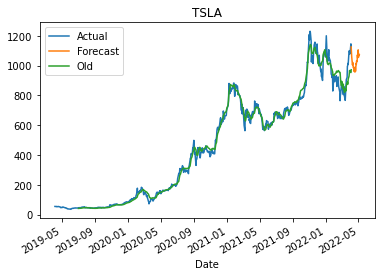

In [68]:
ticker = "TSLA"
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

# download the data
df = yf.download(tickers=[ticker], period='1y')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)
#print(y)
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)
#print(y)

# generate the input and output sequences
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
#print(X.shape, Y.shape)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=1)
tmp = model.predict(X)
#print(tmp)
#print(tmp.shape)
old_preds = []
for i in range(len(tmp)):
    old_preds.append(tmp[i][0])
for i in range(len(tmp[-1])):
    old_preds.append(tmp[-1][i])
#old_preds = np.array(old_preds)
#print(old_preds.shape)
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
#print(len(df_past))
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past['Old'] = np.nan
for i in range(len(old_preds)):
    df_past["Old"].iloc[i+n_lookback-1] = scaler.inverse_transform(np.array(old_preds[i]).reshape(1,-1))

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title=ticker)

### Model With Forward Predictions

[*********************100%***********************]  1 of 1 completed
[array([[0.01607717],
       [0.01578239],
       [0.01563332],
       [0.0162614 ],
       [0.01498179],
       [0.0148612 ],
       [0.01464012],
       [0.01580919],
       [0.01545243],
       [0.01579244],
       [0.01403214],
       [0.01422475],
       [0.01334711],
       [0.01149972],
       [0.0094078 ],
       [0.01046799],
       [0.01000238],
       [0.00921853],
       [0.01090849],
       [0.01273913],
       [0.01279105],
       [0.01140425],
       [0.01103243],
       [0.01055341],
       [0.01014139],
       [0.00804612],
       [0.00893381],
       [0.00887351],
       [0.0082672 ],
       [0.00536966],
       [0.00442001],
       [0.00437311],
       [0.00230464],
       [0.0027669 ],
       [0.00195291],
       [0.00162966],
       [0.00182394],
       [0.00154927],
       [0.00103675],
       [0.        ],
       [0.00245035],
       [0.00295114],
       [0.00451882],
       [0.00427597],
      

<AxesSubplot:title={'center':'TSLA'}, xlabel='Date'>

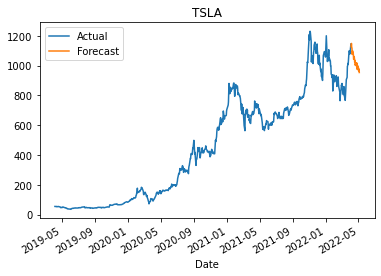

In [69]:
ticker = "TSLA"
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

# download the data
df = yf.download(tickers=[ticker], period='1y')
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)
#print(y)
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)
#print(y)
# generate the input and output sequences


X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])
#print(X)
#print(Y)
X = np.array(X)
Y = np.array(Y)
#print(X.shape, Y.shape)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=1)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title=ticker)

## Multiple Variable Regression

We can also extened time series stuff to deal with multiple varaibles as inputs. For example, for the stock prices we can include the trading volume as well. 

Here our feature set is two values - the price that we are used to with a time series, and also the volume. 

[*********************100%***********************]  1 of 1 completed
(255, 2)
(166, 60, 2) (166,)
Epoch 1/100
6/6 [==============================] - 2s 30ms/step - loss: 0.2636
Epoch 2/100
6/6 [==============================] - 0s 30ms/step - loss: 0.1823
Epoch 3/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0984
Epoch 4/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0438
Epoch 5/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0264
Epoch 6/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0201
Epoch 7/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0170
Epoch 8/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0153
Epoch 9/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0140
Epoch 10/100
6/6 [==============================] - 0s 30ms/step - loss: 0.0124
Epoch 11/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0116
Epoch 12/100
6/6 [=============

/var/folders/px/vhm_920n7zx2wvqq_ht0q5tm0000gp/T/ipykernel_74369/2447995052.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp = np.array(list(zip(Y_,tmp_zeros)))


<AxesSubplot:title={'center':'TSLA'}, xlabel='Date'>

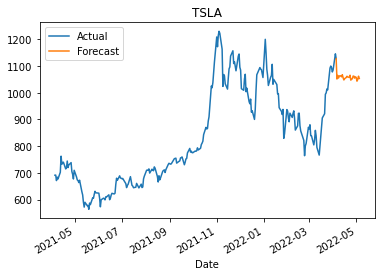

In [71]:
ticker = "TSLA"
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

# download the data
df = yf.download(tickers=[ticker], period='1y')
y = df[['Close', 'Volume']].fillna(method='ffill')
#print(y)
y = y.values.reshape(-1, 2)
#print(y)
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
print(y.shape)
y = scaler.transform(y)
#print(y)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    y_tmp = y[i: i + n_forecast]
    Y.append(y_tmp[0][0])
#print(X)
#print(Y)
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 2)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=1)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 2)

Y_ = model.predict(X_).reshape(-1, 1)
#print(Y_)
tmp_zeros = [0] * len(Y_)
tmp = np.array(list(zip(Y_,tmp_zeros)))
tmp_dict = {"pred":Y_.flatten(), "zero":tmp_zeros}
#print(tmp_dict)
tmp_df = pd.DataFrame.from_dict(tmp_dict)
#print(tmp_df)
Y_ = scaler.inverse_transform(tmp_df)
Y_ = [item[0] for item in Y_]
#print(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_#.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title=ticker)